## Python import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from keras import layers
from keras import models
from keras import Input
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from keras.utils import to_categorical
from keras import regularizers # L2규제

from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import LearningRateScheduler # callbacks 설정

from tqdm.notebook import tqdm # 모델학습 진행 시간 파악
import random # random seed를 뽑을때 사용

#gpu사용
config= tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

In [2]:
print(tf.__version__)

2.3.0


## Load Data

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA

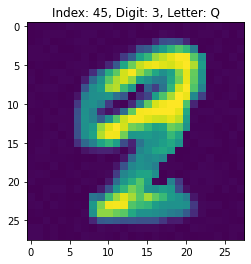

In [4]:
idx = 45
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

## Train model

In [5]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

In [42]:
x_train1 = np.repeat(x_train, 3, axis=1)

In [43]:
x_train2 = np.repeat(x_train1, 3, axis=2)

In [51]:
def create_cnn_model():
    inputs = Input(shape = (84,84,1))
    
    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(64, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)
    
    do=tf.keras.layers.Dropout(0.2)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    do=tf.keras.layers.Dropout(0.2)(pool)
    
    bn = tf.keras.layers.BatchNormalization()(do)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu',kernel_regularizer = regularizers.l2(0.001))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [52]:
create_cnn_model().summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 84, 84, 1)]       0         
_________________________________________________________________
batch_normalization_80 (Batc (None, 84, 84, 1)         4         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 84, 84, 64)        1664      
_________________________________________________________________
batch_normalization_81 (Batc (None, 84, 84, 64)        256       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 84, 84, 64)        16448     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 42, 42, 64)      

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# 이미지 증식 사용
datagen = ImageDataGenerator(
    rotation_range=10,  
    zoom_range = 0.1, 
    width_shift_range=0.1,
    height_shift_range=0.1)

model = create_cnn_model()
epochs=200

#model.fit(x_train, y_train, epochs=50)

history = model.fit(
  datagen.flow(x_train2, y_train, batch_size=16),
  epochs=epochs, 
  steps_per_epoch = x_train2.shape[0]//16,
  callbacks=[annealer], 
  verbose = 1
)

Epoch 1/200
128/128 [==============================] - 3s 23ms/step - loss: 3.7438 - accuracy: 0.3647
Epoch 2/200
128/128 [==============================] - 3s 23ms/step - loss: 2.1847 - accuracy: 0.5361
Epoch 3/200
128/128 [==============================] - 3s 22ms/step - loss: 1.9549 - accuracy: 0.5742
Epoch 4/200
128/128 [==============================] - 3s 23ms/step - loss: 1.7010 - accuracy: 0.6504
Epoch 5/200
128/128 [==============================] - 3s 23ms/step - loss: 1.6104 - accuracy: 0.6807
Epoch 6/200
128/128 [==============================] - 3s 22ms/step - loss: 1.5147 - accuracy: 0.6963
Epoch 7/200
128/128 [==============================] - 3s 22ms/step - loss: 1.3861 - accuracy: 0.7285
Epoch 8/200
128/128 [==============================] - 3s 23ms/step - loss: 1.3307 - accuracy: 0.7441
Epoch 9/200
128/128 [==============================] - 3s 22ms/step - loss: 1.1983 - accuracy: 0.7842
Epoch 10/200
128/128 [==============================] - 3s 22ms/step - loss: 1.132

128/128 [==============================] - 3s 23ms/step - loss: 0.1796 - accuracy: 0.9893
Epoch 81/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1776 - accuracy: 0.9888
Epoch 82/200
128/128 [==============================] - 3s 22ms/step - loss: 0.1720 - accuracy: 0.9932
Epoch 83/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1718 - accuracy: 0.9932
Epoch 84/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1753 - accuracy: 0.9902
Epoch 85/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1666 - accuracy: 0.9917
Epoch 86/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1734 - accuracy: 0.9893
Epoch 87/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1658 - accuracy: 0.9917
Epoch 88/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1766 - accuracy: 0.9873
Epoch 89/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1720 - 

128/128 [==============================] - 3s 23ms/step - loss: 0.1499 - accuracy: 0.9937
Epoch 160/200
128/128 [==============================] - 3s 22ms/step - loss: 0.1545 - accuracy: 0.9932
Epoch 161/200
128/128 [==============================] - 3s 22ms/step - loss: 0.1508 - accuracy: 0.9951
Epoch 162/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1488 - accuracy: 0.9941
Epoch 163/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1563 - accuracy: 0.9941
Epoch 164/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1541 - accuracy: 0.9941
Epoch 165/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1542 - accuracy: 0.9927
Epoch 166/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1588 - accuracy: 0.9897
Epoch 167/200
128/128 [==============================] - 3s 23ms/step - loss: 0.1517 - accuracy: 0.9927
Epoch 168/200
128/128 [==============================] - 3s 23ms/step - loss: 

## Predict

In [ ]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

In [ ]:
x_test1 = np.repeat(x_test, 3, axis=1)

In [ ]:
x_test2 = np.repeat(x_test1, 3, axis=2)

In [ ]:
submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test2), axis=1)
submission.head(50)

In [ ]:
submission.to_csv('3배_do0.2.csv', index=False)